# Rewrite linalg
> Can we replace loops with matrix operations for decision trees?

In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from src.hyperdt.tree import DecisionTreeClassifier


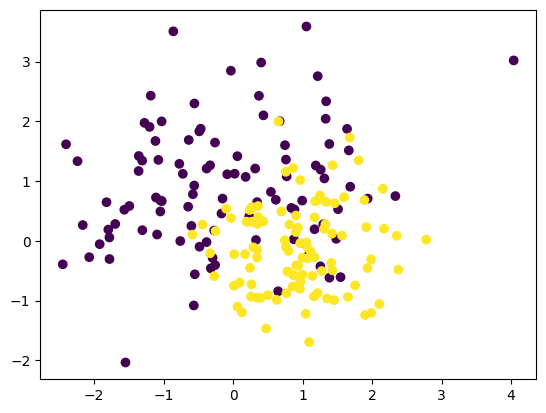

In [117]:
# Basic classification task: mixture of gaussians

X1 = np.random.multivariate_normal(mean=[0, 1], cov=np.eye(2), size=100)
X2 = np.random.multivariate_normal(mean=[1, 0], cov=np.eye(2) * 0.5, size=100)
X = np.vstack([X1, X2])
y = np.hstack([np.zeros(100), np.ones(100)])
y = y.astype(int)

plt.scatter(X[:, 0], X[:, 1], c=y)


In [118]:
# Basic case: get candidates

dt = DecisionTreeClassifier()


def get_candidates(X):
    """Vectorized using ChatGPT :)"""
    n_samples, n_features = X.shape

    # Base matrix filled with zeros
    result = np.zeros((n_features, n_samples, n_features + 1))

    # Setting the ones
    np.put_along_axis(result, np.arange(n_features)[:, None, None], 1, axis=2)

    # Assigning the X values to the last column
    result[:, :, -1] = X.T

    return result.reshape(-1, n_features + 1).T


get_candidates(X)


array([[ 1.        ,  1.        ,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 1.05568391,  0.67191954, -0.0840399 , ...,  0.73142168,
        -0.56448742,  1.73036638]])

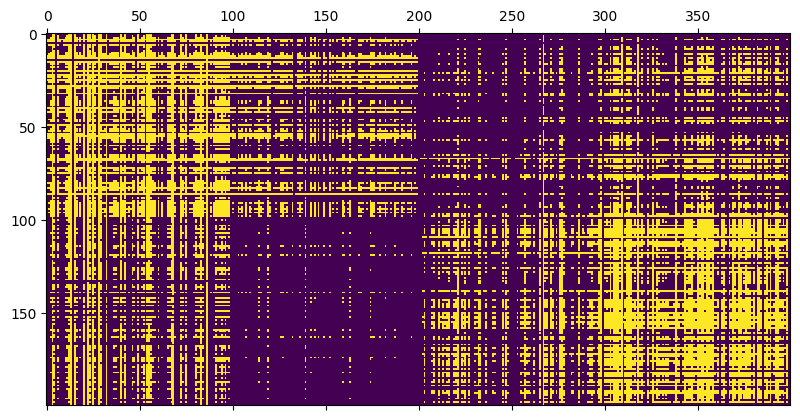

In [134]:
# So the idea is:
# -Change X matrix to have 1s in a final column
# -Multiply by candidates matrix

X_1 = np.hstack((X, np.ones((X.shape[0], 1))))
M = get_candidates(X)

all_products = X_1 @ M
all_products.shape  # (n_samples, n_features * n_samples)
plt.matshow(all_products < 0)


/tmp/ipykernel_2365914/1521633904.py:8: RuntimeWarning: invalid value encountered in divide
  p_positive = positive / total
/tmp/ipykernel_2365914/1521633904.py:9: RuntimeWarning: invalid value encountered in divide
  p_negative = negative / total


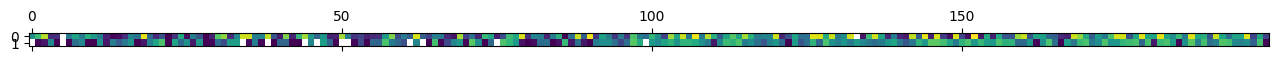

In [135]:
# Compute gini impurities from a sign matrix


def gini_vectorized(y, mask):
    total = np.sum(mask, axis=0)  # One total for each sample
    positive = np.sum(y[:, None] * mask, axis=0)
    negative = total - positive
    p_positive = positive / total
    p_negative = negative / total
    return 1 - p_positive ** 2 - p_negative ** 2


def compute_information_gains(products_matrix, y):
    """Compute a vector of information gains from a sign matrix"""
    n_samples = y.shape[0]

    # Compute masks
    pos_mask = products_matrix > 0
    neg_mask = products_matrix < 0

    # Compute gini impurities
    gini_ones = gini_vectorized(y, pos_mask)
    gini_zeros = gini_vectorized(y, neg_mask)

    # Compute information gains
    prop_ones = np.sum(pos_mask, axis=0) / n_samples
    prop_zeros = np.sum(neg_mask, axis=0) / n_samples
    total_gini = prop_ones * gini_ones + prop_zeros * gini_zeros
    parent_gini = gini_vectorized(y, np.ones_like(y, dtype=bool)[:, None])
    return parent_gini - total_gini


information_gains = compute_information_gains(all_products, y)
plt.matshow(information_gains.reshape(n_features, n_samples))
# Not sure if this is the right order but it's fine


In [136]:
# Replace nans - numpy
information_gains = np.nan_to_num(information_gains, -1)
print(information_gains.max())

dt.fit(X, y.astype(int))
dt.tree.__dict__


0.14430821012140888


{'value': None,
 'probs': None,
 'feature': 0,
 'theta': -0.030463308523019705,
 'left': <src.hyperdt.tree.DecisionNode at 0x7f2af428e010>,
 'right': <src.hyperdt.tree.DecisionNode at 0x7f2af44ce410>,
 'score': 0.146096306685367}

In [139]:
def feature_index(X, idx):
    """Convert index to (dim, theta) pair"""
    n_samples, n_dims = X.shape
    dim = idx // n_samples
    sample_idx = idx % n_samples
    theta = X[sample_idx, dim]
    return dim, theta


feature_index(X, np.argmax(information_gains))


(0, 0.12812529852241017)

In [140]:
M.T[0]


array([1.        , 0.        , 1.05568391])

In [146]:
def dt_info_gain(M_col):
    # First, find which dimension is 1
    dim = np.argmax(M_col[:-1])
    theta = M_col[-1]
    left, right = dt._get_split(X=X, dim=dim, theta=theta)
    print(dim, theta)
    return dt._information_gain(left, right, y)


dt_info_gain(M[:, 0])


0 1.055683913764555


0.02091298806627262

In [144]:
information_gains[:4]


array([0.07142857, 0.0988024 , 0.12834225, 0.0169837 ])

In [149]:
# What if we start from the products matrix?

impurities = np.zeros(all_products.shape[1])
for col in range(all_products.shape[1]):
    prods = all_products[:, col]
    left = prods < 0
    right = prods >= 0
    impurities[col] = dt._information_gain(left, right, y)


/home/phil/hdt/src/hyperdt/tree.py:38: RuntimeWarning: invalid value encountered in divide
  return np.bincount(y, minlength=len(self.classes_)) / len(y)


In [ ]:
# Can we do a version of this


class LinAlgDecisionTreeClassifier(DecisionTreeClassifier):
    def __init__(**kwargs):
        super().__init__(**kwargs)
        self._loss = self._linalg_loss
